https://algebracket.com/?w=90000000000A6050000860000

In [111]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import pandas as pd
import random
import scipy.stats as st
import warnings
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

In [112]:
TOURNEY_DATA_M = pd.read_csv("data/tourney_data_m.csv")
REGULAR_SEASON_DATA = pd.read_csv("data/regular_season_data.csv")
NAME_DATA = pd.read_csv("data/name_data.csv")
SEED_DATA = pd.read_csv("data/seed_data.csv")

In [163]:
def get_model(stats):
    test_year = int(stats[0])
    metrics = stats[1:]
    diff_metrics = [metric + 'DiffAdj' for metric in metrics]

    X = TOURNEY_DATA_M[TOURNEY_DATA_M['Season'] != test_year][diff_metrics]
    y = TOURNEY_DATA_M[TOURNEY_DATA_M['Season'] != test_year]['ScoreDiffAdj']

    model = LinearRegression()
    model.fit(X, y)

    return model

def get_tourney_structure(season, w=False):
    # Generates tournament structure
    # Game Name (Round num + highest seed possible winner)
    # Team 1 ID (or index of previous game, winner is team1)
    # Team 2 ID (or index of previous game, winner is team2)
    # Team 1 seed (or fetched from winner of previous game if 0)
    # Team 2 seed (or fetched from winner of previous game if 0)

    if w == False:
        dat_a = SEED_DATA[(SEED_DATA["Season"] == season) & (SEED_DATA["TeamID"] < 3000)]
    else:
        dat_a = SEED_DATA[(SEED_DATA["Season"] == season) & (SEED_DATA["TeamID"] >= 3000)]

    tourney_structure = []

    play_ins = list(dat_a[dat_a["Seed"].str[-1] == 'a']["Seed"])
    play_ins = [item[:3] for item in play_ins]

    for play_in in play_ins:
        tourney_structure.append(["R0" + play_in, play_in + 'a', play_in + 'b'])

    tourney_structure += [["R1W1", "W01", "W16"], ["R1W8", "W08", "W09"], ["R1W5", "W05", "W12"], ["R1W4", "W04", "W13"], ["R1W6", "W06", "W11"], ["R1W3", "W03", "W14"], ["R1W7", "W07", "W10"], ["R1W2", "W02", "W15"], ["R1X1", "X01", "X16"], ["R1X8", "X08", "X09"], ["R1X5", "X05", "X12"], ["R1X4", "X04", "X13"], ["R1X6", "X06", "X11"], ["R1X3", "X03", "X14"], ["R1X7", "X07", "X10"], ["R1X2", "X02", "X15"], ["R1Y1", "Y01", "Y16"], ["R1Y8", "Y08", "Y09"], ["R1Y5", "Y05", "Y12"], ["R1Y4", "Y04", "Y13"], ["R1Y6", "Y06", "Y11"], ["R1Y3", "Y03", "Y14"], ["R1Y7", "Y07", "Y10"], ["R1Y2", "Y02", "Y15"], ["R1Z1", "Z01", "Z16"], ["R1Z8", "Z08", "Z09"], ["R1Z5", "Z05", "Z12"], ["R1Z4", "Z04", "Z13"], ["R1Z6", "Z06", "Z11"], ["R1Z3", "Z03", "Z14"], ["R1Z7", "Z07", "Z10"], ["R1Z2", "Z02", "Z15"], ["R2W1", 0, 1], ["R2W4", 2, 3], ["R2W3", 4, 5], ["R2W2", 6, 7], ["R2X1", 8, 9], ["R2X4", 10, 11], ["R2X3", 12, 13], ["R2X2", 14, 15], ["R2Y1", 16, 17], ["R2Y4", 18, 19], ["R2Y3", 20, 21], ["R2Y2", 22, 23], ["R2Z1", 24, 25], ["R2Z4", 26, 27], ["R2Z3", 28, 29], ["R2Z2", 30, 31], ["R3W1", 32, 33], ["R3W2", 34, 35], ["R3X1", 36, 37], ["R3X2", 38, 39], ["R3Y1", 40, 41], ["R3Y2", 42, 43], ["R3Z1", 44, 45], ["R3Z2", 46, 47], ["R4W1", 48, 49], ["R4X1", 50, 51], ["R4Y1", 52, 53], ["R4Z1", 54, 55], ["R5WX", 56, 57], ["R5YZ", 58, 59], ["R6CH", 60, 61]]

    id_mapped = []
    for row in tourney_structure:

        if type(row[1]) is not str:
            id_mapped.append([row[0], row[1] + 4, row[2] + 4, 0, 0]) # add 4 to adjust for 4 play-in games
        else:
            if row[1] in play_ins:
                team1 = play_ins.index(row[1])
                seed1 = 0
            else:
                team1 = dat_a[dat_a["Seed"] == row[1]]["TeamID"].iloc[0]
                seed1 = row[1][1:3]

            if row[2] in play_ins:
                team2 = play_ins.index(row[2])
                seed2 = 0
            else:
                team2 = dat_a[dat_a["Seed"] == row[2]]["TeamID"].iloc[0]
                seed2 = row[2][1:3]

            id_mapped.append([row[0], int(team1), int(team2), int(seed1), int(seed2)])

    return id_mapped

def get_metric(team1ID, team2ID, metric, season):
        # return team A metric minus team B metric
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        data1 = REGULAR_SEASON_DATA[(REGULAR_SEASON_DATA['Season'] == season) & (REGULAR_SEASON_DATA['TeamID'] == team1ID)]
        data2 = REGULAR_SEASON_DATA[(REGULAR_SEASON_DATA['Season'] == season) & (REGULAR_SEASON_DATA['TeamID'] == team2ID)]

        assert len(data1) == 1 and len(data2) == 1

        return float(data1[metric].iloc[0]) - float(data2[metric].iloc[0])


def get_a_winner(team1ID, team2ID, teamSeed1, teamSeed2, test_year, model, metrics, hparams=[8, 8], w=False):
    warnings.filterwarnings(action='ignore', category=UserWarning)

    metric_diffs_list = []

    for metric in metrics:
        if metric == "Seed":
            metric_diffs_list.append(teamSeed1 - teamSeed2)
        else:
            metric_diffs_list.append(get_metric(team1ID, team2ID, metric, test_year))

    result = model.predict([metric_diffs_list])

    if result > 0:
        return 1
    else:
        return 0

metrics = ['Seed', 'FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']
test_year = 2024
model = get_model(([test_year] + metrics))
tourney_structure = get_tourney_structure(2024, w=False)

In [ ]:
def fill_bracket(tourney_structure, test_year, model, metrics):
    
    filled_bracket = []

    for row in tourney_structure:
        if row[3] == 0:
            winner_info = filled_bracket[row[1]]
            row[1] = winner_info[1]
            row[3] = winner_info[2]
        if row[4] == 0:
            winner_info = filled_bracket[row[2]]
            row[2] = winner_info[1]
            row[4] = winner_info[2]

        team_1_winner = get_a_winner(row[1], row[2], row[3], row[4], test_year, model, metrics, hparams=[8, 8], w=False)

        if team_1_winner:
            filled_bracket.append([row[0], row[1], row[3]])
            row.append(row[1])
        else:
            filled_bracket.append([row[0], row[2], row[4]])
            row.append(row[2])

    return tourney_structure


def get_team_name(id):
    df = NAME_DATA.loc[NAME_DATA['TeamID'] == id, 'TeamName']
    assert len(df) == 1

    return df.iloc[0]


tourney_structure = fill_bracket(tourney_structure.copy(), test_year, model, metrics)



In [187]:
team_name_list = []

for item in tourney_structure:
    team_name_list.append(get_team_name(item[1]))
    team_name_list.append(get_team_name(item[2]))

team_name_list.append(get_team_name(item[5]))

team_name_list

['Howard',
 'Wagner',
 'Colorado St',
 'Virginia',
 'Grambling',
 'Montana St',
 'Boise St',
 'Colorado',
 'Connecticut',
 'Stetson',
 'FL Atlantic',
 'Northwestern',
 'San Diego St',
 'UAB',
 'Auburn',
 'Yale',
 'BYU',
 'Duquesne',
 'Illinois',
 'Morehead St',
 'Washington St',
 'Drake',
 'Iowa St',
 'S Dakota St',
 'North Carolina',
 'Wagner',
 'Mississippi St',
 'Michigan St',
 "St Mary's CA",
 'Grand Canyon',
 'Alabama',
 'Col Charleston',
 'Clemson',
 'New Mexico',
 'Baylor',
 'Colgate',
 'Dayton',
 'Nevada',
 'Arizona',
 'Long Beach St',
 'Purdue',
 'Montana St',
 'Utah St',
 'TCU',
 'Gonzaga',
 'McNeese St',
 'Kansas',
 'Samford',
 'South Carolina',
 'Oregon',
 'Creighton',
 'Akron',
 'Texas',
 'Colorado St',
 'Tennessee',
 "St Peter's",
 'Houston',
 'Longwood',
 'Nebraska',
 'Texas A&M',
 'Wisconsin',
 'James Madison',
 'Duke',
 'Vermont',
 'Texas Tech',
 'NC State',
 'Kentucky',
 'Oakland',
 'Florida',
 'Boise St',
 'Marquette',
 'WKU',
 'Connecticut',
 'FL Atlantic',
 'San Di

In [189]:
def plot_bracket(team_names, size=(15, 5), tight_layout=False):
    if len(team_names) == 135:
        team_names = team_names[8:]
    if len(team_names) == 127:
        bracket = team_names
        first_round = bracket[:32] + bracket[48:64] + bracket[32:48]
        bracket = bracket[64:]
        rounds = [first_round,
                  bracket[:16] + bracket[24:32] + bracket[16:24],
                  bracket[32:40] + bracket[44:48] + bracket[40:44],
                  bracket[48:52] + bracket[54:56] + bracket[52:54],
                  bracket[56:58] + bracket[59:60] + bracket[58:59],
                  bracket[60:62],
                  bracket[62:63]]
    elif len(team_names) == 63:
        bracket = team_names
        rounds = [bracket[:16] + bracket[24:32] + bracket[16:24],
                  bracket[32:40] + bracket[44:48] + bracket[40:44],
                  bracket[48:52] + bracket[54:56] + bracket[52:54],
                  bracket[56:58] + bracket[59:60] + bracket[58:59],
                  bracket[60:62],
                  bracket[62:63]]

    num_rounds = len(rounds)
    num_teams = len(rounds[0])
    multiplier = 0.6

    fig, ax = plt.subplots(figsize=size)
    ax.set_xlim([0, num_rounds + 1])
    ax.set_ylim([0, num_teams / 2])

    column_height = num_teams / (2 ** (num_rounds - 1))

    prev_ys = []
    new_prev_ys = []

    for r, round_teams in enumerate(rounds):
        round_size = len(round_teams)
        round_height = column_height * round_size

        for t, team_name in enumerate(round_teams):
            if t < round_size // 2:
                x = r * multiplier
                if len(prev_ys) == 0:
                    y = (column_height * (2 * t + 1)) - round_height / 2
                else:
                    y = (prev_ys[2 * t] + prev_ys[2 * t + 1]) / 2
                new_prev_ys.append(y)
            else:
                x = num_rounds - (r * multiplier)
                if len(prev_ys) == 0:
                    y = (column_height * (2 * (t - round_size // 2) + 1)) - round_height / 2
                else:
                    y = (prev_ys[2 * t] + prev_ys[2 * t + 1]) / 2
                new_prev_ys.append(y)

            if r == num_rounds - 1:
                x = num_rounds / 2

            if team_name == rounds[-1][0]:
                ax.text(x, y, team_name, ha='center', va='center', fontsize=8, bbox=dict(facecolor='none', edgecolor='green'))
            else:
                ax.text(x, y, team_name, ha='center', va='center', fontsize=8)
        prev_ys = new_prev_ys
        new_prev_ys = []

    ax.invert_yaxis()
    ax.axis('off')
    if tight_layout:
        plt.tight_layout()
    else:
        plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    plt.show()
    

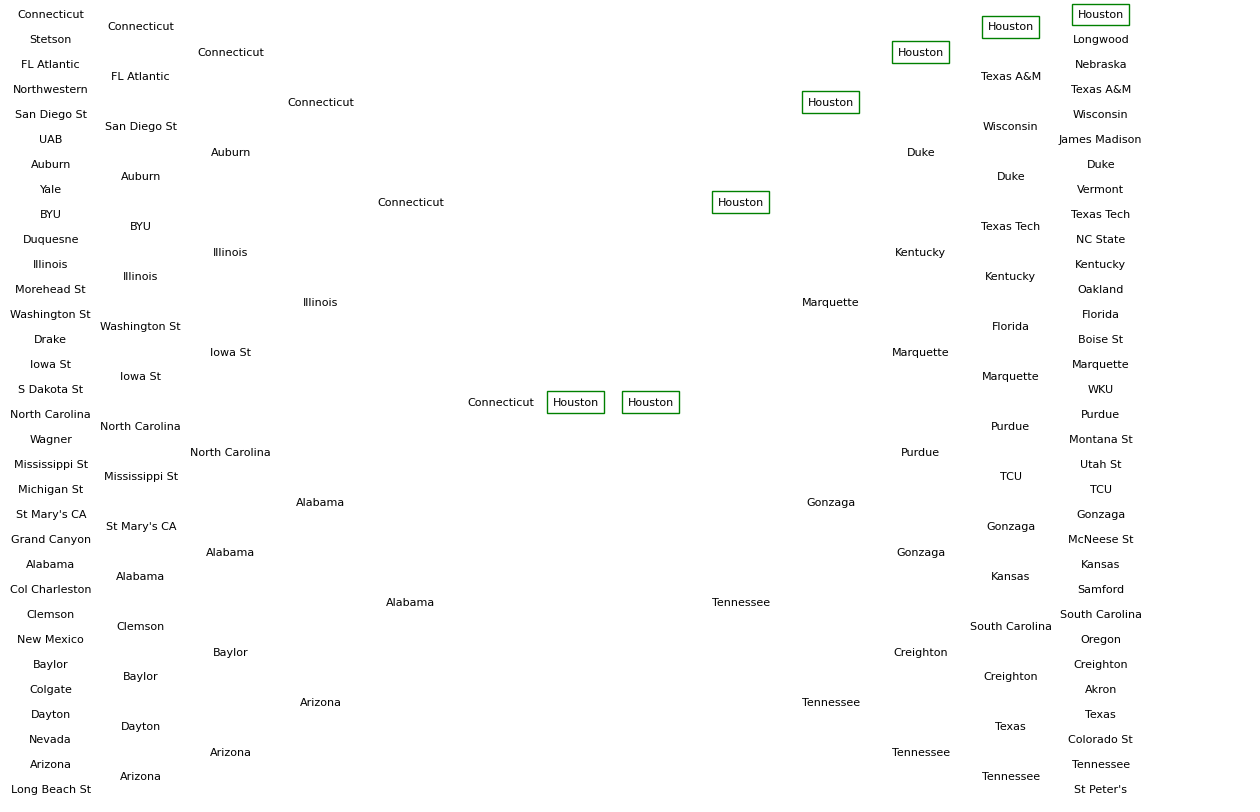

In [190]:
plot_bracket(team_name_list)

# Code to generate `regular_season_data.csv`

In [37]:
team_list = list(set(list(METRIC_DATA['WTeamID']) + list(METRIC_DATA['LTeamID'])))

In [55]:
def get_metric(teamID, metric, season):
    warnings.simplefilter(action='ignore', category=RuntimeWarning)
    metric_data_season = METRIC_DATA[METRIC_DATA['Season'] == season]

    team1score = (np.mean(np.array(metric_data_season[metric_data_season['WTeamID'] == teamID]['W' + metric])) + np.mean(np.array(metric_data_season[metric_data_season['LTeamID'] == teamID]['L' + metric]))) / 2

    if np.isnan(team1score):
        mean1 = np.mean(np.array(metric_data_season[metric_data_season['WTeamID'] == teamID]['W' + metric]))
        mean2 = np.mean(np.array(metric_data_season[metric_data_season['LTeamID'] == teamID]['L' + metric]))

        # assert not (np.isnan(mean1) and np.isnan(mean2))

        if np.isnan(mean1):
            team1score = mean2
        else:
            team1score = mean1

    return team1score

results = []

for year in [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]:
    print(year, end = ' ')
    for team in team_list:
        dat = {'TeamID' : team, 'Season' : year}
        
        for metric in ['FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']:
            dat[metric] = get_metric(team, metric, year)

        results.append(dat)

2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2021 2022 2023 2024 

In [60]:
df = pd.DataFrame(results)

csv_path = "data/regular_season_data.csv"
df.to_csv(csv_path, index=False)